# About
This notebook is a playground for me to explore and demonstrate the use of fundamental data science concepts. I'll focus solving the binary classification problem using logistic regression. 

## Concepts covered
* Logistic regression
* Class imbalance
* Threshold tuning
* Confusion matrics
* ROCH and Precision-Recall curves 
* Area-under-curve (AUC) metric
* Bias-variance tradeoff

## Main tools used
* `Scikit-learn` for the machine learning
* `Pandas` for data analysis
* `Seaborn` and `Matplotlib` for visualization

# Imports, setups

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import sklearn.metrics as metrics
from sklearn.metrics import log_loss
from scipy.special import expit
import random

# Load and preprocess data

# Logistic regression

In logistic regressions, we predict the _probability_ of stroke $p$ assuming that the relationsship between $p$ and the features $x$ can be described by the [logistic function](https://en.wikipedia.org/wiki/Logistic_function).

\begin{equation}
p = \frac{1}{1 + e^{-(k\cdot x + k_0)}}, 
\end{equation}

where $k$ is a vector of weights, one for each feature, that needs to be fit to the data and $k_c$ is a constant (the "intercept") which determines the centering of the logistic function.

The probability of stroke $p$ is a continuous variable which needs to be transformed into a discrete-valued prediction $y$ ($\in 0, 1$), where 0 and 1 mean "no stroke" and "stroke", respectively.
This is done by choosing a threshold parameter $T$, such that $p>T \iff y=1$, and otherwise $y=0$.

Notes:
* $0 <p < 1$, consistently with it being a probability
* This is a linear model in terms of the so-called logit (log of the odds): $\text{logit} := \ln \frac{p}{1-p} = k\cdot x + k_c$
* All variables in the equation are numerical (as is the case generally for regression) so our categorical values need to be transformed using [one-hot-encoding](https://en.wikipedia.org/wiki/One-hot), in which each categorical value is represented by a binary numerical variable (0 or 1).

# Regression for dataset with categorical features
To understand the basics of logistic regression and the effect of including or not including given variables as features in the modeling, I first experiment with a hand-generated dataset.

In [3]:
def generate_data(seed=None, num_points=5000, yweights=None):
    yweights = yweights or [[100, 1], [100, 20]]
    random.seed(seed)

    # 2 binary candidate features, x0 and x1
    x0 = random.choices([0,1], k=num_points, weights=[1,1])
    x1 = random.choices([0,1], k=num_points, weights=[1,1])

    # Binary target y is positively correlated with x0, 
    y = [random.choices([0,1], weights=yweights[0], k=1)[0] if not x else random.choices([0,1], weights=yweights[1], k=1)[0] for x in x0]

    return pd.DataFrame({'x0':x0, 'x1': x1, 'y':y})

In [4]:
df = generate_data(seed=1)

I summarize the data with a bar plot, showing the estimated mean value of y, $\bar{y}$. Since $y$ is a binary, $\bar{y}$ is exactly an estimate of the probability of $y=1$: 
\begin{equation} 
p = P(y=1) = 1\cdot P(y=1) + 0 \cdot P(y=0) \approx \frac{1}{n}\sum_{i=1}^n y_i= \bar{y}
\end{equation}

The figure looks like expected: 
1) It's clear that $x_0 = 1$ correlates with larger $y$, meaning that it should be a good predictor of $y$.
2) There is no clear correlation between the value of $x_1$ and the value of $y$, meaning $x_1$ is likely not an important or helpful feature.


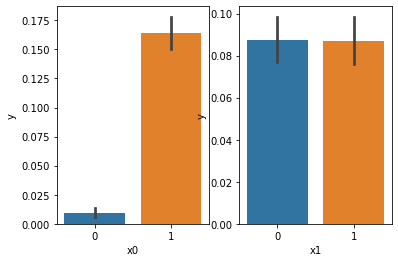

In [5]:
fig, ax = plt.subplots(1,2);
sns.barplot(x='x0', y='y', data=df, ax=ax[0])
sns.barplot(x='x1', y='y', data=df, ax=ax[1]);

It's worth noting, that these conclusions are not as evident for a smaller dataset. Using only the first 100 samples from the same dataset, the uncertainty (error bars) are relatively larger and instead of the second conclusion, one might guess (incorrectly) that also $x_1$ is a good predictor for $y$.

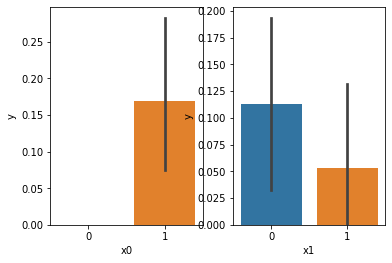

In [6]:
fig, ax = plt.subplots(1,2);
sns.barplot(x='x0', y='y', data=df[:100], ax=ax[0])
sns.barplot(x='x1', y='y', data=df[:100], ax=ax[1]);

I'm interested in understanding better the effect of including $x_1$ or not as a feature. I'll demonstrate the effect both visually and quantitatively. First, fit two models; one based on $x_0$ only and another based on both $x_0$ and $x_1$:

In [7]:
logistic_0 = LogisticRegression() # x0 only
logistic_1 = LogisticRegression()  # x1 only
logistic_01 = LogisticRegression() # x0, x1 only

logistic_0.fit(X=df[['x0']], y=df['y'])
logistic_1.fit(X=df[['x1']], y=df['y'])
logistic_01.fit(X=df[['x0', 'x1']], y=df['y'])

print("Coeffs, intercept using x0 only", logistic_0.coef_, logistic_0.intercept_)
print("Coeffs, intercept using x1", logistic_1.coef_, logistic_1.intercept_)
print("Coeffs, intercept using x0, x1", logistic_01.coef_, logistic_01.intercept_)

Coeffs, intercept using x0 only [[2.91839069]] [-4.55461079]
Coeffs, intercept using x1 [[-0.00627788]] [-2.34773034]
Coeffs, intercept using x0, x1 [[2.91846793 0.00871739]] [-4.5589582]


Above, the coefficient for $x_1$, $k_1$, is small relative to the coefficient of $x_0$, $k_0$, confirming that the latter is more predictive of $y$. The sign of $k_1$ is just due to randomness -- we known that $y$ is independent of $x_1$. 

Interestingly, the sign of $k_1$ changes depending on whether $x_0$ is included as a feature or only $x_1$ is a feature (it's magnitude remains small). We can get a hint of why that would happen by looking at some statistics of $y$ as a fucntion of $(x_0, x_1)$:

In [8]:
tmp = df.groupby(['x1']).describe()[[('y', s) for s in ('count', 'mean')]]
tmp.columns = [' '.join(c) for c in tmp.columns]
tmp['diff y mean'] = tmp['y mean'].diff()
display(tmp)

tmp = df.groupby(['x0', 'x1']).describe()[[('y', s) for s in ('count', 'mean')]]
tmp.columns = [' '.join(c) for c in tmp.columns]
tmp['diff y mean'] = tmp['y mean'].sort_index(level=1).diff(periods=2).sort_index(level=0) # differences between  x1 values, given x0 value
display(tmp)

,y count,y mean,diff y mean
x1,,,
0,2533.0,0.087248,NaN
1,2467.0,0.086745,-0.000503


y count    y mean  diff y mean
x0 x1                                
0  0    1252.0  0.007188          NaN
   1    1238.0  0.011309     0.004120
1  0    1281.0  0.165496          NaN
   1    1229.0  0.162734    -0.002762

When considering only $x_1$ (top table), the mean value of $y$ decreases slightly with $x_1$, just by chance. That explains why $k_1$ is negative.


However, when considering also information about $x_0$ (bottom table) there are two cases to consider: for $x_0 = 0$, $\bar{y}$ _increases_ with $x_1$, while for $x_0=1$, $\bar{y}$ _decreases_ with $x_0$. In this case, the end effect in balancing this tradoeff is a positive $k_1$, i.e. a model predicting that $p$ increases with when changing only $x_1$.

We can visualize the effect of including $x_0$, $x_1$ or both in the modeling by plotting the predicted probability $p$ as a function of either feature:

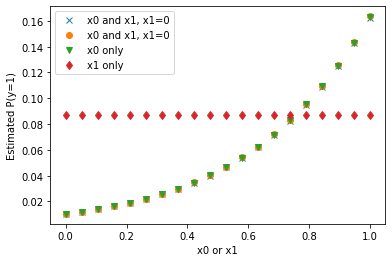

In [9]:
# This is just for me to check that I know what scikit-learn parameters are. 
# Make sure below that LogisticRegression.predict_proba method it returns the same probabilities.
def logistic_function(x, k, kc):
    """Return logistic function value of data x."""
    x = x.reshape((len(x), -1))
    return expit((x * k).sum(axis=1) + kc)

# In reality, x = 0, 1
x = np.linspace(0,1, 20).reshape((-1,1))
fig, ax = plt.subplots(1)

X = np.hstack([x, np.zeros(x.shape)])
p = logistic_function(X, logistic_01.coef_, logistic_01.intercept_)
p_ref = logistic_01.predict_proba(X)[:,1]
assert (np.isclose(p, p_ref)).all()
ax.plot(X[:,0], p, 'x', label='x0 and x1, x1=0')

X = np.hstack([x, np.ones(x.shape)])
p = logistic_function(X, logistic_01.coef_, logistic_01.intercept_)
p_ref = logistic_01.predict_proba(X)[:,1]
assert (np.isclose(p, p_ref)).all()
ax.plot(X[:,0], p, 'o', label='x0 and x1, x1=0')

p = logistic_function(x, logistic_0.coef_, logistic_0.intercept_)
p_ref = logistic_0.predict_proba(x)[:,1]
assert (np.isclose(p, p_ref)).all()
ax.plot(x, p, 'v', label="x0 only")

p = logistic_function(x, logistic_1.coef_, logistic_1.intercept_)
p_ref = logistic_1.predict_proba(x)[:,1]
assert (np.isclose(p, p_ref)).all()
ax.plot(x, p, 'd', label="x1 only")

plt.xlabel("x0 or x1")
plt.ylabel("Estimated P(y=1)")
plt.legend();

We see that including $x_0$ is important for catching the correlations in the data, while the effect of inclduing $x_1$ or not is barely visible.  

# Cross-entropy loss function
The effect of including or not including $x_0$ can be quantified by calculating the loss function used for the fit, 
[the cross-entropy loss function](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) or simply, the *log loss*.
The mean loss can be calculated either using functionality from `scikit-learn` or by writing a small function. We see that including $x_0$ leads to a smaller (training) loss, consistent with being a better model:

In [11]:
def cross_entropy(y, yhat):
    # Here, yhat = P(y=1)
    # L(y, yhat) = - [y*ln(yhat) + (1-yhat)*ln(1-yhat)]
    return -(y*np.log(yhat) + (1-y)*np.log(1-yhat))

for model, xs in zip([logistic_01, logistic_0, logistic_1], [['x0', 'x1'], ['x0'], ['x1']]):
    p = model.predict_proba(df[xs])

    # p = predicted probability of y=1
    mean_loss = np.mean(cross_entropy(df.y, p[:,1]))

    if not np.isclose(mean_loss, log_loss(y_true=df.y, y_pred=p)): raise
    print(f"Mean cross-entropy for {xs}: {mean_loss:.4f}")

Mean cross-entropy for ['x0', 'x1']: 0.2503
Mean cross-entropy for ['x0']: 0.2503
Mean cross-entropy for ['x1']: 0.2955


# Confusion matrix
Given the outcome of a classifer on a dataset, the confusion matrix shows the distribution of predictd values (predicted values; columns) for the negative and positive populations (true value; rows). There is one confusion matrix for each classification outcome, i.e. for each threshold and model. 

In [12]:
def thresholds_list(p):
    thresholds = sorted(set(p))
    thresholds.append(thresholds[-1]+1)
    return thresholds

In [13]:
def display_confusion_matrix(y_true, y_pred, normalize=None):
    cm = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred, normalize=normalize))
    cm.axes[0].name = "True"
    cm.axes[1].name = "Predicted"
    display(cm)

In [14]:
p = logistic_01.predict_proba(df[['x0', 'x1']])[:,1]
y_true = df.y 
thresholds = thresholds_list(p)
for t in thresholds:
    print(f"Threshold = {t}")
    y_pred = [int(p_y >= t) for p_y in p]
    display_confusion_matrix(y_true, y_pred)

Threshold = 0.010364417853795976


Predicted,0,1
True,,
0,0,4565
1,0,435


Threshold = 0.010454214782547917


Predicted,0,1
True,,
0,1243,3322
1,9,426


Threshold = 0.16239836286735568


Predicted,0,1
True,,
0,2467,2098
1,23,412


Threshold = 0.1635876391697693


Predicted,0,1
True,,
0,3536,1029
1,235,200


Threshold = 1.1635876391697693


Predicted,0,1
True,,
0,4565,0
1,435,0


# ROC and precision-recall curves
[The `sklearn.metrics` module](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) 
provides several metrics for binary classification evaluation, that I want to demonstrate here. 
To begin, I'll plot [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) 
and [precision-recall](https://en.wikipedia.org/wiki/Precision_and_recall) (PR) curves in order to compare the logistic regression models as classifiers. Both ROC and PR have the true positive rate (TPR), on the y-axis. TPR estimates the probability that a positive sample will be correctly labeled as positive. 

 \begin{equation}
 \text{TPR} = \text{recall} = P(\hat{y}=1 | y=1)
 \end{equation}
   
The difference between ROC and PR lies in that ROC has the false positive rate (FPR) on the other axis while PR uses precision.
FPR estimates the probability that a negative sample will be incorrectly labeled as positive  
   
\begin{equation}
\text{FPR} = P(\hat{y}=1 | y=0)
\end{equation}
   
Precision estimates the probability that a positively labeled sample is a positive sample, and so 1-precision estimate the probability that a positively labeled sample is a negative sample.

\begin{equation}   
   \text{precision} = P(y=1 | \hat{y}=1), \iff
   1- \text{precision} = P(y=0 | \hat{y}=1)
 \end{equation}

I use 1-precision rather than precision in order to make the ROC and PR curves easier to compare in the same figure.
Above, the predicted label $\hat{y}$ will depend on the chosen classification threshold. Each point in the ROC and PR curves represent a different threshold value.

Now let's plot these curves for a test dataset.

In [15]:
# Generate new data for model testing
df_test = generate_data(seed=2)

In [16]:
def plot_roc_pr_curves(models, data, x_names, y_name='y', debug=False):
    fig, (ax0, ax1) = plt.subplots(1,2, sharey=True)
    for model, xs in zip(models, x_names):
        p = model.predict_proba(data[xs])[:,1]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(data[y_name], p)
        ax0.plot(fpr, tpr, 'o--',  label=xs)
        
        # PR
        precision, recall, pr_thresholds = metrics.precision_recall_curve(data[y_name], p)
        ax1.plot(1-precision, recall, 'o--', label=xs)
        
        if debug:
            print(f"model {xs}:")
            print()
            print("ROC data")
            # The first threshold is just defined to be soemthing arbitrary that is larger than the largest element of p, so that TPR = 0.
            for x, y, t in reversed(list(zip(fpr, tpr, roc_thresholds))):
                print(f"x={x}, y={y}, threshold={t}")
                ax0.annotate(text=f"{t:.4f}", xy=(x,y), xytext=(-20, +10), textcoords='offset points', color='red', bbox=dict(boxstyle="round", fc='white', ec='gray'))
            print()
            print("PR data")
            # Add threshold > max(p) which reproduces the zero TPR value
            for x, y, t in zip(1-precision, recall, [*pr_thresholds, max(p)+1]):
                print(f"x={x}, y={y}, threshold={t}")
                ax1.annotate(text=f"{t:.4f}", xy=(x,y), xytext=(-20, +10), textcoords='offset points', color='red', bbox=dict(boxstyle="round", fc='white', ec='gray'))
            print()
            print("-"*80)

    ax0.legend()
    ax0.set_xlabel('False positive rate')
    ax0.set_ylabel('True positive rate');
    ax0.set_title("ROC");

    ax1.legend()
    ax1.set_xlabel('1-precision')
    ax1.set_ylabel('True positive rate (=recall)');
    ax1.set_title("Precision-recall");

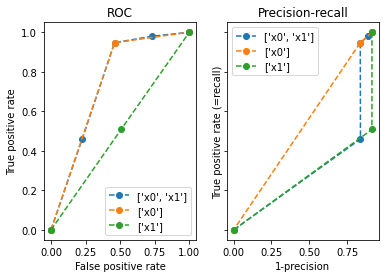

In [17]:
plot_roc_pr_curves(models=[logistic_01, logistic_0, logistic_1], data=df, x_names=[['x0', 'x1'], ['x0'], ['x1']], debug=False)

When choosing a threshold for a model based on either of these curves, we want to stay as high as possible on the y-axis to detect as many of the positive samples as possible, while  keeping the x-value as low as possible to keep the number of false positives low. For instance, the ROC curve shows that for $\text{TPR} \lesssim 0.9$ FPR can quite efficiently be traded for FPR (steep slope), but to reach even higher TPR values, the cost in terms of FPR becomes greater (flat slope).

We can also use the curves to differentiate between models and select the better one. Here, the ROC curve tells us that either model including $x_0$ has higher TPR values for a given FPR value than the model including only the dummy feature $x_1$. Based on the PR curve we see that there are clear differences between the $x_0$ model and the $x_0, x_1$ model for certain threshold values.

We can understand the difference between the ROC and PR curves by focusing in detail on a the $x_0, x_1$ model where they are clearly different:

model ['x0', 'x1']:

ROC data
x=1.0, y=1.0, threshold=0.010364417853795976
x=0.727710843373494, y=0.9793103448275862, threshold=0.010454214782547917
x=0.4595837897042716, y=0.9471264367816092, threshold=0.16239836286735568
x=0.22541073384446877, y=0.45977011494252873, threshold=0.1635876391697693
x=0.0, y=0.0, threshold=1.1635876391697693

PR data
x=0.913, y=1.0, threshold=0.010364417853795976
x=0.8863393810032018, y=0.9793103448275862, threshold=0.010454214782547917
x=0.8358565737051793, y=0.9471264367816092, threshold=0.16239836286735568
x=0.8372660699755899, y=0.45977011494252873, threshold=0.1635876391697693
x=0.0, y=0.0, threshold=1.1635876391697693

--------------------------------------------------------------------------------


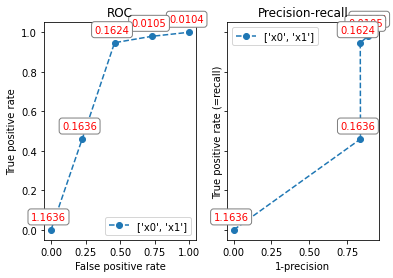

In [18]:
plot_roc_pr_curves(models=[logistic_01], data=df, x_names=[['x0', 'x1']], debug=True)

Above, the thresholds are annotated with red. The y-values of the points are the same in the ROC and the PR curve, as they were obtained using the same thresholds, but the x-values are not. The thresholds represent something specific very in this case: each threshold value corresponds to an observed _state_ of the feature space and equals the predicted probability of that state. When going from a lower to a higher threshold value, that entails transfering a state from positive class ($\hat{y}=1$) to the negative class ($\hat{y}=0)$. In this case, there are 4 different states, each corresponding to a combination of $x_0$, $x_1$ (the 5th, highest threshold is just an arbitrary value with $T > \max p$):

In [19]:
i=0
negative = []
for x0 in [0, 1]:
    for x1 in [0, 1]:
        p = logistic_01.predict_proba(np.array([x0, x1]).reshape((1, 2)))[:, 1][0]
        print(f"T{i} = p({x0}, {x1}) = {p:.4f}; negative set = {negative}")
        negative.append((x0, x1))
        i+=1

T0 = p(0, 0) = 0.0104; negative set = []
T1 = p(0, 1) = 0.0105; negative set = [(0, 0)]
T2 = p(1, 0) = 0.1624; negative set = [(0, 0), (0, 1)]
T3 = p(1, 1) = 0.1636; negative set = [(0, 0), (0, 1), (1, 0)]


So, moving backwards along the ROC curve, we see that the $(\text{TPR}, \text{FPR})=(1,1)$ point corresponds to setting the threshold $T_0$ so low that all observations are in the positively labeled set, i.e. $T_0 \le p(x_0, x_1), \forall~(x_0, x_1)$ 
In this case, it means $T_0 = \min p(x_0, x_1) = p(0, 0)$.
Increasing the threshold one step to $T_1 = p(0, 1)$
excludes $(0,0)$ samples from the positive set.
At $T_2 = p(1, 0)$  also $(0,1)$ is excluded from the positive set, which now consists of $(1,0)$ and $(1,1)$ samples. At this threshold we are actually splitting the data into positive and negative sets based on the $x_0$ value, which makes a lot of sense based on how the data was generated!

So far, the effect off changing the threshold has been limited in terms of TPR, so we are still quite good there, while the FPR has decreased significantly, from 1 to $\sim0.4$, which is also good! 
Increasing the threshold further, $T_3 = p(1,1)$ starts excluding $x_0=1$ samples of type $(1,0)$ from the positive set based on the $x_1$ value. This doesn't make sense knowing the data, but since in a real case we don't have such information we want to deduce that from the curves. Indeed, we see the TPR drops by about 50% to $\sim0.4$ which is bad. FPR also decreases by about 50%. Basically, increasing the threshold has just randomly divided the positive set in half. This shows how the *FPR can always be decreased by simply detecting less*, without the model doing anything more intelligent than a random model. 

This is where the PR curve is different from the ROC curve.  From the PR curve, we see that precision does *not* increase by this last change in threshold ($T_2 \to T_3$). On the contrary, the precision stays essentially constant and even decreases slightly (for this dataset, due to randomness). The reason is that the two curves normalize the number of false positives in different ways. FPR, used by ROC, normalizes the number of false positives to the total number of negative samples in the population. Precision, used by PR, normalizes the number of false positives to the population of positively labeled samples.


# Threshold tuning
So which threshold should one pick? This really comes down to matter of putting a _cost_ on the errors (see also [this blog post](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28) for more detailed discussion). The question is how does one trade a false positive for a false negative? This right answer is subjective, up to a decision-maker, and problem-specific. For instance, in the case of an imbalanced dataset (like this one), it often happens that for any observation, it's more likely that the sample is negative than positive simply because the positive condition is rare. If the cost of a making a false negative error and false positive error were equal, then the best mathematically best classifier would always predict negative, i.e. the model does _nothing_ and we wouldn't need to train a model at all! However, often classifier problems are such that the cost of a false negative (missing a positive) is higher than the cost of a false positive (false alarm). For instance, one may want to use a classifier as a first stage of a process to find people at risk of getting a disease. Then further medical tests can give more accurate answers. In this case, there will be a cost associated with missing people who actually get the disease without discovering it in time and another cost associated with performing the extra medical assesment on people who where never at risk to begin with. This cost-balance can be settled by setting a minimum TPR and a maximum FPR (ROC) or minimum precision (PR). Also in this toy example it means that for a given model either threshold _could_ be the more optimal one depending on the requirements of the end user.

In some cases it makes more sense to express the cost of a false-positive in relation to to the negative population (FPR), while in other cases expressing the cost relative to the positively predicted population (precision) makes more practical sense. 

Say for instance that the current case represents some robots in a factory and we are predicting whether they need extra maintenance or not. Then we might put a strong constraint on the max false positive rate, say $<25\%$, because every robot that is unnecessarily transported out of the factory floor (false positive) will mean a direct loss of income and there has to be at least a certain number of robots on the floor. We can assume that the cost of not giving extra maintenanc even though it could have helped (false negative) will just make the robot work a bit slower, which can be detected later on. This could make us pick $T3$ for practical reasons even though in this case there is no real reason to differentiate between $(1,0)$ and $(1, 1)$ samples! However, in this case looking at the PR curve would still give us the extra piece of information that $T_3$ does not offer higher precision than $T_2$. This could lead us to re-evaluate the chosen features of the robots, or pick $T_2$ and out of the predicted positive candidates, pick a max number $n$ to actually carry off for maintenance.  

There are other examples where it makes more sense to use precision for quantifying the cost of false positives. For instance, say we are mining a big rock for gold and using a classifier to predict whether some lumps of material have gold (1, positive) or not (0, negative). The material detected as gold will be sold on to some refinement facility. The sell price will be higher the percentage of gold is. Here, there is a cost to not finding all the gold in the rock (false negative), because of lost income in not trying to sell it. There is also a cost to adding impurities of plain rock (false positives) to the gold-labeled batch, because the refinery will pay less for it. Here, the total amount of plain rock is not so relevant for expressing this cost. Rather, the acceptable number of false positives depends on the number of true positives, so it makes sense to look exactly at precision (not FPR).

We can conclude:
* $x_0$-only model is the best because it gives the highest TPR for _any_ threshold. 
* the $x_0, x_1$ model can give the same performance as $x_0$ only but it makes our life harder because the threshold needs tuned to "fix" the fact that $x_1$ doesn't actually have any information on $y$.
* The $x_1$-only model doesn't perform better than random ($\text{TPR}\approx0.5$). The only thing the model picks up is the constant fraction of positives (0.87). This is not nothing, but has nothing to do with the value of $x_1$.

# Area-under-curve (AUC) metrics
Instead of looking at the ROC or PR curves, the curves can be summarized with a _single_ metric, the area under the curves (AUC). The [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)  can be interpreted as the probability that a randomly picked positive sample gets a higher probability score ($p$) than a randomly picked negative sample (see also [derivation](https://stats.stackexchange.com/questions/180638/how-to-derive-the-probabilistic-interpretation-of-the-auc)). 

In [20]:
def plot_auc(models, data, x_names, y_name='y', debug=False):
    auc_rocs = []
    auc_prs = []
    for model, xs in zip(models, x_names):
        p = model.predict_proba(data[xs])[:,1]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(data[y_name], p)
        auc_roc = metrics.roc_auc_score(data[y_name], p)
        x, y, _ = metrics.roc_curve(data[y_name], p)
        auc_roc_alt = metrics.auc(x, y)
        assert np.isclose(auc_roc, auc_roc_alt)
        
        # PR
        precision, recall, pr_thresholds = metrics.precision_recall_curve(data[y_name], p)
        x, y = recall, precision

        # x required to be monotonous, recall is.
        # area under precision-vs-recall curve =  area under recall-vs-(1-precision) curve.
        auc_pr = metrics.auc(x, y)
            
        auc_rocs.append(auc_roc)
        auc_prs.append(auc_pr)
        
        if debug:
            print(f"model {xs}:")
            print(f"Number of integration points: {len(x)}")
            print(f"AUC-ROC: {auc_roc}")
            print(f"AUC-PR:{auc_pr}")
            print("-"*80)

    fig, (ax0, ax1) = plt.subplots(1,2, sharey=False)
    ax0.plot(auc_rocs, 'o--', label='AUC ROC')
    ax1.plot(auc_prs, 'o--', label='AUC PR')

    ax0.set_xticks([0,1,2])
    ax0.set_xticklabels(x_names)
    ax0.legend()
    ax1.set_xticks([0,1,2])
    ax1.set_xticklabels(x_names)
    ax1.legend()


model ['x0', 'x1']:
Number of integration points: 5
AUC-ROC: 0.7442844733164634
AUC-PR:0.3534942387926584
--------------------------------------------------------------------------------
model ['x0']:
Number of integration points: 3
AUC-ROC: 0.7437713235386688
AUC-PR:0.5579349315382149
--------------------------------------------------------------------------------
model ['x1']:
Number of integration points: 3
AUC-ROC: 0.5007918822625927
AUC-PR:0.31904714957957264
--------------------------------------------------------------------------------


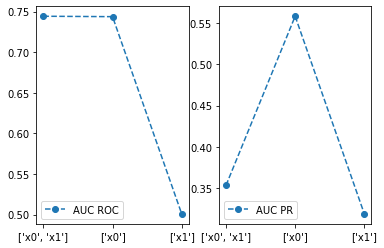

In [21]:
plot_auc(models=[logistic_01, logistic_0, logistic_1], data=df, x_names=[['x0', 'x1'], ['x0'], ['x1']], debug=True)

Based on this metric we would choose $x_0$ for modeling since it gets the highest AUC. 

Note: In this case, there is no obvious meaning to the value of the interpolated curve _between_ points of different thresholds. If the features $x_i$ are continuous, such that there is a continuum of states with different predicted probabilities, the interpolation makes more sense because any TPR value $\in [0,1]$  corresponds to a unique threshold value $T$.

# F1 score
Another way to summarize a confusion matrix with one number and asessing the tradeoff between false positive vs false negative errors is using the [F1 score](https://en.wikipedia.org/wiki/F-score). Rather than looking at two counteracting variables at the same time as as when plotting ROC/PR curves, F1 is a single number, an average of TPR/recall and precision. The F1 score uses the harmonic mean $x_h = \left(\sum_i x_i^{-1}\right)^{-1}$, of precision and recall

\begin{equation}
F1 = \frac{2}{\text{precision}^{-1} + \text{recall}^{-1}}  = 2\frac{\text{recall}\cdot\text{precision}}{\text{recall} + \text{precision}}.
\end{equation}

Because of the product in the nominator, the $F1$ score is sensitive to small values of precision or recall. This is desirable since the F1 score can only be high (as we want) if both precision and recall are simultaneously high.

In [22]:
def plot_F1(models, data, x_names, y_name='y', debug=False):
    fig, ax = plt.subplots(1,1)
    for model, xs in zip(models, x_names):
        p = model.predict_proba(data[xs])[:,1]
        thresholds = sorted(set(p))
        thresholds.append(thresholds[-1]+1)
        y_true = data[y_name] 

        # calculate F1 for all thresholds using scikit-learn function
        f1 = []
        for t in thresholds:        
            y_pred = [1 if p_y >= t else 0 for p_y in p]
            f1.append(metrics.f1_score(y_true, y_pred))
            
        # Or calculate using precision, recall definition.
        precision, recall, thresh = metrics.precision_recall_curve(y_true, p)
        f1_ = [2*pr*rec/(pr+rec) for pr, rec in zip(precision, recall)]
            
        assert(all(np.isclose(f1_, f1)))

        #fpr, tpr, roc_thresholds = metrics.roc_curve(data[y_name], p)
        # The F1 takes not the predicted probability of of each sample but the predicted classes. thus the threshold needs to be set.
        #        metrics.f1_score(data[y_name, p])
        ax.plot(thresholds, f1, 'o--',  label=xs)

    ax.legend()
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1');
    ax.set_title("F1 scores");

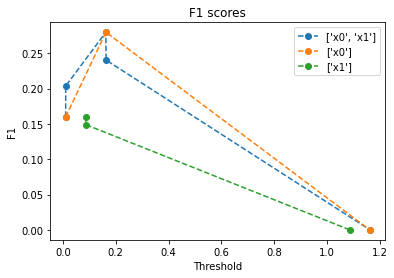

In [23]:
plot_F1(models=[logistic_01, logistic_0, logistic_1], data=df, x_names=[['x0', 'x1'], ['x0'], ['x1']], debug=True)

Here it's also clear that the winner model is one of the models including $x_0$. Occam's razor (simplicity) would make us pick $x_0$.

# Effects of dataset sizes

## Small training dataset
The only thing that matters for the shape of the ROC curve, modeling-wise, is the ranking of predicted probabilities $p$ of the observed states. Different model features willl give rise to different states and so will change the ROC curve, but for the same set of features  the relative ordering of predicted probabilities determine the ROC curve. For the $x_0$-model  it means that as long as $\hat{p}(x_0=1) > \hat{p}(x_0=0)$ the ROC curve will stay the same irrespective of the exact value of the model coefficients and $\hat{p}$, which also aligns well with the probabilistic interpretation of AUC for the ROC curve. This also means that the exact composition of the training data is _not critical_ unless it so poorly represents the true data that it leads to a model fit which mixes up the correct ordering of which states are more or less likely to have $y=1$. Here I want to investigate closer how the size of the training dataset influences the ROC curve analysis, for both the $x_0$-only and the $x_0, x_1$ model.   

Of course, when plotting the ROC curve using a test dataset the size of the dataset will be important because it determines the distribution of states and so, how much the ROC curve changes at each data point (each change of threshold value). 
To eliminate the sampling aspect of the *test data* and only investigate sampling aspects of the *training data*, I use a very large test dataset below, approximating the true distribution.

So, I train the $x0$ and $x_0, x_1$ models on small datasets (30 samples) using 100 different seeds for generating training data. I summarize the ROC curves using AUC and plot the distribution of AUC values:


In [24]:
def sample_auc_vary_train(xs, train_size=30, test_size=100_000, debug=False, num_samples=100):
    """Sample ROC and PR AUC values for different training data, same test data."""
    d_test = generate_data(num_points=test_size, seed=0)
    if debug:
        print(f"num y in test = {np.sum(d_test.y)}")
        print("-"*70)
        
    iseed=1
    aucs_roc, aucs_pr = [], []
    for i in range(num_samples):
        #if i%10 == 0:
        #    print(i)

        # Bias the training data slightly, ignore training data sets without any y=1
        while True:
            d = generate_data(num_points=train_size, seed=iseed)
            iseed += 1
            if sum(d.y) > 0:
                break   
            #print("no y=1")

        # Train
        model = LogisticRegression()
        model.fit(d[xs], d.y)

        # Evaluate
        p = model.predict_proba(d_test[xs])[:,1]

        # ROC
        auc = metrics.roc_auc_score(d_test.y, p)
        aucs_roc.append(auc)
        
        # PR
        precision, recall, thresholds = metrics.precision_recall_curve(d_test.y, p)

        # x required to be monotonous, recall is.
        # area under precision-vs-recall curve =  area under recall-vs-(1-precision) curve.
        auc = metrics.auc(recall, precision)
        aucs_pr.append(auc)

        if debug:
            print(i)
            print(f"num y in train = {np.sum(d.y)}")
            print("coeffs", model.coef_, model.intercept_)
            print(f"auc={auc}")
            print("thresholds", thresholds_list(p)[:-1])
            print(tpr)
            print()
    
    return aucs_roc, aucs_pr

In [28]:
def auc_stats(aucs, name="AUC"):
    """ Print stats for list of AUCS and plot counts."""
    aucs = pd.Series(aucs, name='AUC')
   
    print(f"Stats for {name}:")
    print("Counts:")
    print(aucs.value_counts())
    print()
    print("Stats:")
    print(aucs.describe())
    
def plot_auc_counts(aucs, name="AUC", ax=None):
    aucs = pd.Series(aucs, name='AUC')
    if not ax:
        plt.figure()
        ax = plt.gca()
    sns.countplot(x=aucs, ax=ax)    
    ax.set_xlabel("Different AUC values")
    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels([f"{float(text.get_text()):.3f}" for text in xticklabels])
    ax.set_title(name)

In [26]:
# Sample (small training dataset)
aucs_roc_01, aucs_pr_01  = sample_auc_vary_train(['x0', 'x1'])
aucs_roc_0, aucs_pr_0 = sample_auc_vary_train(['x0'])

In [31]:
# Print stats

# ROC
auc_stats(aucs_roc_0, name="AUC ROC x0")
print("="*80)
auc_stats(aucs_roc_01, name="AUC ROC x0, x1")
print("="*80)

# PR
auc_stats(aucs_pr_0, name="AUC PR x0")
print("="*80)
auc_stats(aucs_pr_01, name="AUC PR x0, x1")
print("="*80)

Stats for AUC ROC x0:
Counts:
0.741627    98
0.258373     2
Name: AUC, dtype: int64

Stats:
count    100.000000
mean       0.731962
std        0.067996
min        0.258373
25%        0.741627
50%        0.741627
75%        0.741627
max        0.741627
Name: AUC, dtype: float64
Stats for AUC ROC x0, x1:
Counts:
0.742386    43
0.740869    37
0.621302    10
0.620328     5
0.378698     2
0.681844     2
0.257614     1
Name: AUC, dtype: int64

Stats:
count    100.000000
mean       0.710281
std        0.079454
min        0.257614
25%        0.740869
50%        0.740869
75%        0.742386
max        0.742386
Name: AUC, dtype: float64
Stats for AUC PR x0:
Counts:
0.555518    98
0.076437     2
Name: AUC, dtype: int64

Stats:
count    100.000000
mean       0.545936
std        0.067409
min        0.076437
25%        0.555518
50%        0.555518
75%        0.555518
max        0.555518
Name: AUC, dtype: float64
Stats for AUC PR x0, x1:
Counts:
0.358581    43
0.359350    37
0.327613    10
0.328748  

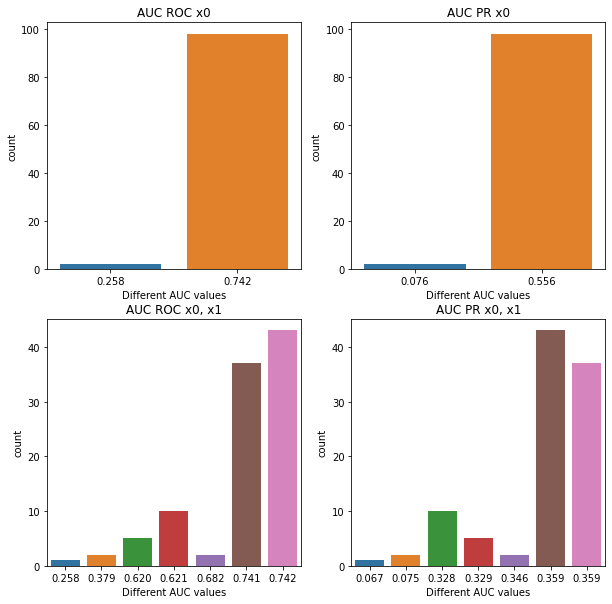

In [32]:
# Plot AUC
fig, axes = plt.subplots(2, 2, figsize=(10,10))

# ROC
plot_auc_counts(aucs_roc_0, name="AUC ROC x0", ax=axes[0, 0])
plot_auc_counts(aucs_roc_01, name="AUC ROC x0, x1", ax=axes[1,0])

# PR
plot_auc_counts(aucs_pr_0, name="AUC PR x0", ax=axes[0, 1])
plot_auc_counts(aucs_pr_01, name="AUC PR x0, x1", ax=axes[1,1])

From the count distribution plots it's evident that for small training datasets, including an extra feature which doesn't add useful information for the prediciton leads to a greater spread in the AUC distribution, in particular toward lower AUC values. This is bad because it shows that the model training becomes less robust to variations in the training data. The reason is that the extra feature and model parameter increases the risk that the model will overfit to the dataset, i.e. fit to noise in the training data. Small datasets don't represent the true distribution well. Especially the positive sample distribution is affected the small training dataset, because there are fewer positive samples of overall due to the imbalance of negative to positive samples. For instance it could happen by chance that there are more $y=1$ samples with $x0=0$ than $x0=1$, but drawing the conclusion that $x_0$ increases the probability of $y=1$ is incorrect. 

We see that ROC and PR curves show similar variation of AUC for small training datasets: there is a tail toward low (worse) AUC values. The main difference between ROC and PR is that the distributions are centered around different AUC values, in absolute terms. Also, for both PR and ROC, the distribution converges toward the highest AUC values when using a 10x-larger training dataset:

## Larger training dataset
When increasing the training dataset, the training data will move closer to the true distribution which mitigates negative effect of adding the extra unnecessary feature. This can be seen as a smaller spread in AUC values, making the disitrbution for the two model types more similar for either ROC or PR AUC:

In [33]:
# Sample with 10x larger training dataset
aucs_roc_01, aucs_pr_01  = sample_auc_vary_train(['x0', 'x1'], train_size=300)
aucs_roc_0, aucs_pr_0 = sample_auc_vary_train(['x0'], train_size=300)

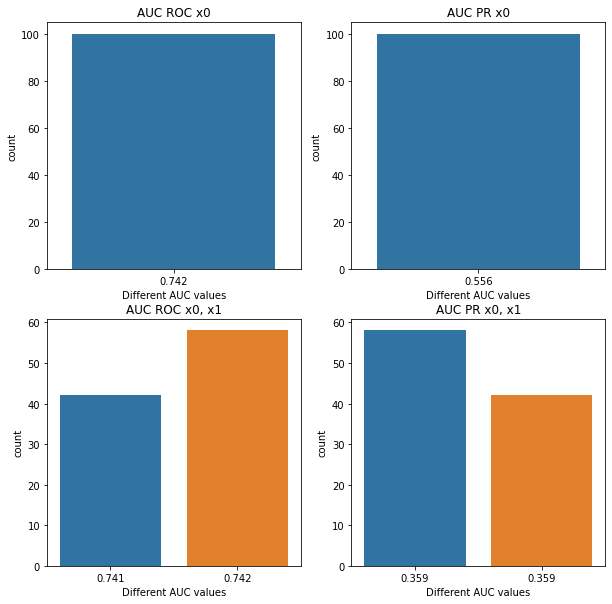

In [34]:
# Plot AUC
fig, axes = plt.subplots(2, 2, figsize=(10,10))

# ROC
plot_auc_counts(aucs_roc_0, name="AUC ROC x0", ax=axes[0, 0])
plot_auc_counts(aucs_roc_01, name="AUC ROC x0, x1", ax=axes[1,0])

# PR
plot_auc_counts(aucs_pr_0, name="AUC PR x0", ax=axes[0, 1])
plot_auc_counts(aucs_pr_01, name="AUC PR x0, x1", ax=axes[1,1])

This is an example of the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) in modeling: when there there is little data, a more complex model will overfit to the data (high variance) while when there is more data, the problem is shifted toward simple models not fitting well enough to the data. This is not the best example of the bias-variance tradeoff however, since in this case the more complex model will never be better than the simpler model since it is just modeling noise. So the effect is simply to reduce the impact of model complexity.

## Size of test dataset
Another aspect to look at is the influence of the test data on the evaluation metric, here AUC, given a model (good or bad) for different test data sets of a given size. 

In [35]:
def sample_auc_vary_test(xs, train_size=30, test_size=30, num_samples=100, debug=False, seed=0):
    """Sample ROC and PR AUC values for same training data, vary test data."""
    # Train
    d = generate_data(num_points=train_size, seed=seed)

    # Train
    model = LogisticRegression()
    model.fit(d[xs], d.y)

    # Evaluate
    iseed=1
    aucs_roc, aucs_pr = [], []
    for i in range(num_samples):
        while True:
            d_test = generate_data(num_points=test_size, seed=iseed)
            iseed += 1
            if sum(d_test.y) > 0:
                break   
        if debug:
            print(f"num y in test = {np.sum(d_test.y)}")
            print("-"*70)
        
        p = model.predict_proba(d_test[xs])[:,1]

        # ROC
        auc = metrics.roc_auc_score(d_test.y, p)
        aucs_roc.append(auc)
        
        # PR
        precision, recall, thresholds = metrics.precision_recall_curve(d_test.y, p)

        # x required to be monotonous, recall is.
        # area under precision-vs-recall curve =  area under recall-vs-(1-precision) curve.
        auc = metrics.auc(recall, precision)
        aucs_pr.append(auc)

        if debug:
            print(i)
            print(f"num y in train = {np.sum(d.y)}")
            print("coeffs", model.coef_, model.intercept_)
            print(f"auc={auc}")
            print("thresholds", thresholds_list(p)[:-1])
            print(tpr)
            print()
    
    return aucs_roc, aucs_pr

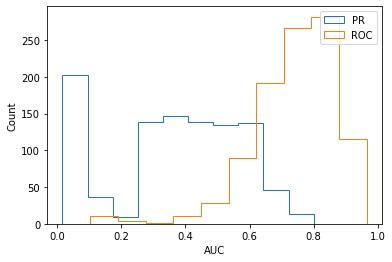

In [36]:
# Sample different (small) test sets to evaluate a single model.
aucs_roc, aucs_pr = sample_auc_vary_test(['x0', 'x1'], num_samples=1000)

plt.hist(aucs_pr, histtype='step', label='PR ')
plt.hist(aucs_roc, histtype='step', label='ROC')
plt.legend()
plt.xlabel('AUC')
plt.ylabel('Count');

Interestingly, the shape of the distributions are somewhat different. More importantly, a feature that both distributions have in common is a significant spread. This shows the importance of keeping a large enough dataset for the evaluation part of the modeling in order to be able to distinguish between different models and get a reliable estimate of the true performance of the model.

We can summarize these AUC distributions using the mean and standard deviations and plotting them as a function of the test dataset size visualize how these distributions narrow down and converge to the "true" metric value of that model.

In [37]:
auc_roc_means = []
auc_roc_stds = []
auc_pr_means = []
auc_pr_stds = []
test_sizes = [100, 1_000, 10_000, 100_000]
for test_size in test_sizes:
    aucs_roc, aucs_pr = sample_auc_vary_test(['x0', 'x1'], num_samples=100, test_size=test_size)
    auc_roc_means.append(np.mean(aucs_roc))
    auc_roc_stds.append(np.std(aucs_roc))    
    auc_pr_means.append(np.mean(aucs_pr))
    auc_pr_stds.append(np.std(aucs_pr))   

Text(0, 0.5, 'AUC')

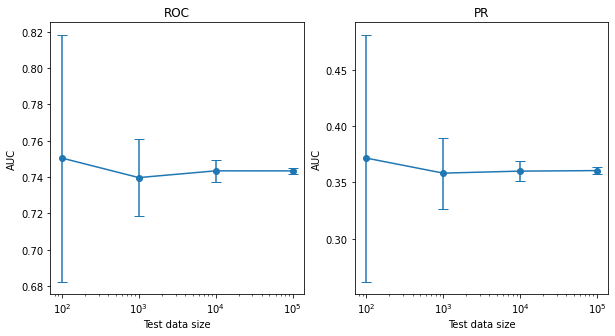

In [38]:
fig, axes = plt.subplots(1,2, sharey=False, figsize=(10,5))
ax = axes[0]
ax.set_xscale('log', base=10)
ax.errorbar(x=test_sizes, y=auc_roc_means, xerr=None, yerr=auc_roc_stds, fmt='o-', capsize=5)
ax.set_title('ROC');
ax.set_xlabel('Test data size')
ax.set_ylabel('AUC')

ax = axes[1]
ax.set_xscale('log', base=10)
ax.errorbar(x=test_sizes, y=auc_pr_means, xerr=None, yerr=auc_pr_stds, fmt='o-', capsize=5)
ax.set_title('PR');
ax.set_xlabel('Test data size')
ax.set_ylabel('AUC')

Again, ROC and PR show similar (relative) behaviour.

# ROC vs PR and imbalanced datasets
It is often said that PR is "better" than ROC for imbalanced datasets, where $P(y=0) \gg P(y=1)$ (as was the case here too). However, as was discussed already above, what is best really depends on the problem and what costs are being considering when choosing a threshold for the model. This forum thread on the topic 
[ROC vs precision-and-recall curves](https://stats.stackexchange.com/questions/7207/roc-vs-precision-and-recall-curves) 
provides an overview and some insight. In this context, 
[a paper from 2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/), which is clearly in favor of using the PR curve, is often referenced. However, in that paper  assumptions are made about what kind of problems are considered and so what metrics are most relevant (in that case, the PR curve evidently). There is also some discussion on the topic in 
[this Wikipedia article](https://en.wikipedia.org/wiki/Precision_and_recall#Imbalanced_data).

In practice, a precision-type metric can make more sense for the classification problem because it may directly translate into a interpretable cost (or value). Often in imbalanced cases, the positively labeled set is the only thing that the end-user of the model will see or perform work with, so the quality of that set is what matters. For example, a person searching the web cares about the number of irrelevant results (false positives) relative to the number of relevant results (true positives), not relative to the sea of irrelevant results that were never presented to them (true negatives). 

A fundamental difference between using FPR (ROC curve) and precision (PR curve) for that purpose is that FPR "divides out" the imbalance in the dataset, the baseline probability $P(y=1)$, while PR is picks up this baseline. If the model is expected to be  used on populations with different baselines, one needs to be aware of this. The ROC curve will provide an invariant metric, which is good if you want to evaluate the model itself for _any_ population. But if precision is a quantity inherently of interest due to the nature of the problem then the variation of PR curves across populations with different baselines would still be be relevant to analyze to get an estimate of the uncertainty of model performance. So really, one curve is not objectively better than the other. Rather, it depends.

# Further reading and other metrics
The ROC and PR curves and the AUC, F1 metrics are the most well-known and used in the data science community, which is one reason for using them. However there are also other metrics, which can be argued to be better or complementary and which are worth at least being aware of, see e.g. the [paper by Powers](https://arxiv.org/ftp/arxiv/papers/2010/2010.16061.pdf).
Examples of such metrics include:
[F-measures](https://en.wikipedia.org/wiki/Precision_and_recall#F-measure), [Cohens Kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa),
[Informedness/Youden's J statistic](https://en.wikipedia.org/wiki/Youden%27s_J_statistic) and [Markedness](https://en.wikipedia.org/wiki/Markedness). 
See also [this review of ROC analysis](https://people.inf.elte.hu/kiss/13dwhdm/roc.pdf).
